In [1]:
%%capture
!pip install kaggle

In [2]:
%%capture
!pip install albumentations

In [3]:
%%capture
!pip install -U segmentation-models-pytorch

In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import random
from tqdm import tqdm, tnrange
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
plt.style.use("ggplot")
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# PyTorch related libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import albumentations as album

from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from PIL import Image

# segmentation models for PyTorch
import segmentation_models_pytorch as smp

In [5]:
torch.set_default_dtype(torch.float32)

In [6]:
# Downloading dataset from kaggle
# upload kaggle.json

# Import necessary library for file upload
from IPython.display import display, FileLink
from pathlib import Path

# Assuming kaggle.json is in the current directory and you're in a Jupyter Notebook environment
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset to a directory of your choice, here we use 'data'
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation -p data

Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
100%|███████████████████████████████████████▊| 711M/714M [00:29<00:00, 27.5MB/s]
100%|████████████████████████████████████████| 714M/714M [00:29<00:00, 25.0MB/s]


In [7]:
# Unzip the dataset
!unzip data/lgg-mri-segmentation.zip -d data/dataset

Archive:  data/lgg-mri-segmentation.zip
  inflating: data/dataset/kaggle_3m/README.md  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_13_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14.tif  
  i

  inflating: data/dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_13_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_14.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_14_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_15.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_15_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_16.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_16_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_17.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_17_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_18.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_18_ma

  inflating: data/dataset/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_8.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_8_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_9.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_9_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_10.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_10_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_11.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_11_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_12.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_12_mask.tif  
 

  inflating: data/dataset/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_12.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_12_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_13.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_13_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_14.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_14_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_15.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_15_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_16.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_16_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_17.ti

  inflating: data/dataset/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_12_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_13.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_13_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_14.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_14_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_15.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_15_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_16.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_16_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_17.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6290_20000917/TCGA_CS_6290_20000917_17_ma

  inflating: data/dataset/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_20.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_20_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_21.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_21_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_22.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_22_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_23.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_23_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_24.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_24_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6666_20011109/TCGA_CS_6666_20011109_25.ti

  inflating: data/dataset/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_27.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_27_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_28.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_28_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_2_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_3.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_3_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_4.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_4_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_5.tif  
  inflating: data/dataset/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_5_mask.tif 

  inflating: data/dataset/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_28.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_28_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_29.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_29_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_2_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_3.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_30.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_30_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_31.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_31_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_32.tif 

  inflating: data/dataset/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_37.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_37_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_38.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_38_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_39.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_39_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_3_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_4.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_40.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_40_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_4_mask.

  inflating: data/dataset/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_12_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_13.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_13_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_14.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_14_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_15.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_15_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_16.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_16_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_17.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5853_19950823/TCGA_DU_5853_19950823_17_ma

  inflating: data/dataset/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_23_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_24.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_24_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_25.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_25_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_26.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_26_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_27.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_27_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_28.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_28_ma

  inflating: data/dataset/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_15.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_15_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_16.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_16_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_17.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_17_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_18.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_18_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_19.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_19_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_1_mas

  inflating: data/dataset/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_2_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_3.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_30.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_30_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_31.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_31_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_32.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_32_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_33.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_33_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_34.tif 

  inflating: data/dataset/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_9_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_1.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_10.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_10_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_11.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_11_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_12.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_12_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_13.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_13_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_5874_19950510/TCGA_DU_5874_19950510_14.tif 

  inflating: data/dataset/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_22.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_22_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_23.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_23_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_24.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_24_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_25.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_25_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_26.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_26_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_27.ti

  inflating: data/dataset/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_19.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_19_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_1_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_2.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_20.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_20_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_21.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_21_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_22.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_22_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_23.tif 

  inflating: data/dataset/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_11.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_11_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_12.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_12_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_13.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_13_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_14.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_14_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_15.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_15_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_16.ti

  inflating: data/dataset/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_8_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_9.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_9_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_1.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_10.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_10_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_11.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_11_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_12.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_12_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_13.tif  


  inflating: data/dataset/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_52.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_52_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_53.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_53_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_5_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_6.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_6_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_7.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_7_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_8.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_8_mask.tif 

  inflating: data/dataset/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_5.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_50.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_50_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_51.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_51_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_52.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_52_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_53.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_53_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_54.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_54_mask.tif

  inflating: data/dataset/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_42.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_42_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_43.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_43_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_44.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_44_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_45.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_45_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_46.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_46_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_47.ti

  inflating: data/dataset/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_35.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_35_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_36.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_36_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_37.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_37_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_38.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_38_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_39.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_39_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_3_mas

  inflating: data/dataset/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_3.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_30.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_30_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_31.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_31_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_32.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_32_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_33.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_33_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_34.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_34_mask.tif

  inflating: data/dataset/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_27_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_28.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_28_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_29.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_29_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_2_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_3.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_30.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_30_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_31.tif 

  inflating: data/dataset/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_1_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_2.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_20.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_20_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_21.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_21_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_22.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_22_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_23.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_23_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_24.tif 

  inflating: data/dataset/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_23.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_23_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_24.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_24_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_25.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_25_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_26.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_26_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_27.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_27_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_28.ti

  inflating: data/dataset/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_13_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_14.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_14_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_15.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_15_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_16.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_16_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_17.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_17_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_18.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_18_ma

  inflating: data/dataset/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_2_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_3.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_30.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_30_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_31.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_31_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_32.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_32_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_33.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_33_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7019_19940908/TCGA_DU_7019_19940908_34.tif 

  inflating: data/dataset/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_14.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_14_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_15.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_15_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_16.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_16_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_17.ti

  inflating: data/dataset/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_30.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_30_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_31.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_31_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_32.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_32_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_33.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_33_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_34.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_34_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_35.ti

  inflating: data/dataset/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_16.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_16_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_17.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_17_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_18.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_18_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_19.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_19_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_1_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_2.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_20.tif 

  inflating: data/dataset/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_34_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_35.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_35_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_36.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_36_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_3_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_4.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_4_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_5.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_5_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_6.tif

  inflating: data/dataset/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_19.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_19_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_1_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_2.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_20.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_20_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_21.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_21_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_22.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_22_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_23.tif 

  inflating: data/dataset/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_30.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_30_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_31.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_31_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_32.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_32_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_33.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_33_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_34.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_34_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_35.ti

  inflating: data/dataset/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_12.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_12_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_13.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_13_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_14.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_14_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_15.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_15_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_16.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_16_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_17.ti

  inflating: data/dataset/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_27.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_27_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_28.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_28_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_29.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_29_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_2_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_3.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_30.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_30_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_31.tif 

  inflating: data/dataset/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_12.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_12_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_13.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_13_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_14.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_14_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_15.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_15_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_16.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_16_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_17.ti

  inflating: data/dataset/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_28.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_28_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_29.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_29_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_2_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_3.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_30.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_30_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_31.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_31_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_32.tif 

  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_11_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_12.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_12_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_13.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_13_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_14.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_14_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_15.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_15_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_16.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_16_ma

  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_26_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_27.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_27_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_28.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_28_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_29.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_29_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_2_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_3.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_30.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_30_mask

  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_9.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_9_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_1.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_10.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_10_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_11.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_11_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_12.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_12_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_13.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_13_mask.tif  

  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_9_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_1.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_10.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_10_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_11.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_11_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_12.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_12_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_13.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_13_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_14.tif 

  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_8.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_8_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_9.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TW_19980228/TCGA_DU_A5TW_19980228_9_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_1.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_10.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_10_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_11.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_11_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_12.tif  
  inflating: data/dataset/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_12_mask.tif  
 

  inflating: data/dataset/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_24_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_2_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_3.tif  
  inflating: data/dataset/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_3_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_4.tif  
  inflating: data/dataset/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_4_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_5.tif  
  inflating: data/dataset/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_5_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_6.tif  
  inflating: data/dataset/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_6_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_EZ_7264_20010816/TCGA_EZ_7264_20010816_7.tif  
 

  inflating: data/dataset/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_14.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_14_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_15.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_15_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_16.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_16_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_17.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_17_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_18.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_18_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_19.ti

  inflating: data/dataset/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_33_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_34.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_34_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_35.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_35_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_36.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_36_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_3_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_4.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_4_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_5.t

  inflating: data/dataset/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_43_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_44.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_44_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_45.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_45_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_46.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_46_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_47.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_47_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_48.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_48_ma

  inflating: data/dataset/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_47_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_48.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_48_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_49.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_49_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_4_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_5.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_50.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_50_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_51.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_51_mask

  inflating: data/dataset/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_4.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_40.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_40_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_41.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_41_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_42.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_42_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_43.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_43_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_44.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_44_mask.tif

  inflating: data/dataset/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_18.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_18_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_19.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_19_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_1_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_2.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_20.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_20_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_21.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_21_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_22.tif 

  inflating: data/dataset/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_40.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_40_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_41.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_41_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_42.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_42_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_43.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_43_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_44.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_44_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_45.ti

  inflating: data/dataset/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_41.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_41_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_42.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_42_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_43.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_43_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_44.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_44_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_45.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_45_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_46.ti

  inflating: data/dataset/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_41.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_41_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_42.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_42_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_43.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_43_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_44.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_44_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_45.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_45_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_46.ti

  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_33.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_33_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_34.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_34_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_35.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_35_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_36.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_36_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_37.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_37_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_38.ti

  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_33.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_33_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_34.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_34_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_35.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_35_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_36.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_36_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_3_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_4.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_4_mask.

  inflating: data/dataset/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_57.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_57_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_58.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_58_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_59.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_59_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_5_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_6.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_60.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_60_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_61.tif 

  inflating: data/dataset/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_14.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_14_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_15.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_15_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_16.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_16_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_17.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_17_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_18.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_18_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_19.ti

  inflating: data/dataset/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_16.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_16_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_17.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_17_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_18.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_18_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_19.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_19_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_1_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_2.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_20.tif 

  inflating: data/dataset/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_7.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_7_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_8.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_8_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_9.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_9_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_1.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_10.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_10_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_11.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7616_19940813/TCGA_HT_7616_19940813_11_mask.tif  
  i

  inflating: data/dataset/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_10.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_10_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_11.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_11_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_12.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_12_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_13.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_13_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_14.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_14_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_15.ti

  inflating: data/dataset/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_18_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_19.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_19_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_1_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_2.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_20.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_20_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_21.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_21_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_22.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_22_mask

  inflating: data/dataset/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_9.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_9_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_1.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_10.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_10_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_11.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_11_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_12.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_12_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_13.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7694_19950404/TCGA_HT_7694_19950404_13_mask.tif  

  inflating: data/dataset/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_18.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_18_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_19.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_19_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_1_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_2.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_20.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_20_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_21.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_21_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_22.tif 

  inflating: data/dataset/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_2.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_20.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_20_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_2_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_3.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_3_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_4.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_4_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_5.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_5_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_6.tif  
  inf

  inflating: data/dataset/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_26_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_27.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_27_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_28.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_28_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_2_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_3.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_3_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_4.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_4_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_5.tif

  inflating: data/dataset/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_49.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_49_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_4_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_5.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_50.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_50_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_51.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_51_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_52.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_52_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_53.tif 

  inflating: data/dataset/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_25.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_25_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_26.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_26_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_27.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_27_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_28.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_28_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_29.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_29_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_2_mas

  inflating: data/dataset/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_6.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_6_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_7.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_7_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_8.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_8_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_9.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_9_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_1.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_10.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8105_19980826/TCGA_HT_8105_19980826_10_mask.tif  
  inf

  inflating: data/dataset/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_1.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_10.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_10_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_11.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_11_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_12.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_12_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_13.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_13_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_14.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8107_19980708/TCGA_HT_8107_19980708_14_mask.tif

  inflating: data/dataset/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_2.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_20.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_20_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_21.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_21_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_2_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_3.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_3_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_4.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_4_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_5.tif  
  i

  inflating: data/dataset/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_8_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_9.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_9_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_1.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_10.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_10_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_11.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_11_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_12.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_12_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_13.tif  


  inflating: data/dataset/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_7.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_7_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_8.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_8_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_9.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_9_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_1.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_10.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_10_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_11.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_11_mask.tif  
  i

  inflating: data/dataset/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_57_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_58.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_58_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_59.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_59_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_5_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_6.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_60.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_60_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_61.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_61_mask

  inflating: data/dataset/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_31.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_31_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_32.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_32_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_33.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_33_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_34.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_34_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_35.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_35_mask.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_36.ti

  inflating: data/dataset/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_9.tif  
  inflating: data/dataset/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_9_mask.tif  
  inflating: data/dataset/kaggle_3m/data.csv  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/README.md  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif  
  inflating: data/dataset/lgg-mri-

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_14_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_15.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_15_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_16.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_16_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_17.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_17_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_18.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_7.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_7_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_8.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_8_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_9.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_9_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_10.tif 

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_14.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_14_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_15.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_15_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_16.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_16_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_17.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315_17_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_5397_20010315/TCGA_CS_5397_20010315

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_18_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_19.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_19_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_1_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_2.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_20.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_20_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_21.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_2

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_4.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_4_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_5.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_5_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_6.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_6_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_7.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_7_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6665_20010817/TCGA_CS_6665_20010817_8.tif  

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_10.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_10_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_11.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_11_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_12.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_12_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_13.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025_13_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6668_20011025/TCGA_CS_6668_20011025

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_12_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_13.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_13_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_14.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_14_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_15.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_15_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405_16.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5849_19950405/TCGA_DU_5849_19950405

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_22_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_23.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_23_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_24.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_24_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_25.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_25_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_26.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_34_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_35.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_35_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_36.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_36_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_3_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_4.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_19950709_4_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5852_19950709/TCGA_DU_5852_199507

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_18.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_18_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_19.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_19_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_1_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_2.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_20.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_20_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5854_19951104/TCGA_DU_5854_19951104_2

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_8_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_9.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5855_19951217/TCGA_DU_5855_19951217_9_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_1.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_10.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_10_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_11.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_11_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5871_19941206/TCGA_DU_5871_19941206_12.

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_20_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_21.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_21_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_22.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_22_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_23.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_23_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_24.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_62.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_62_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_63.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_63_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_64.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_64_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_65.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_65_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_10.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_10_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_11.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_11_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_12.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_12_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_13.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_13_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_52.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_52_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_53.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_53_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_5_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_6.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_6_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_7.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6399_19830416/TCGA_DU_6399_19830416_7_m

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_40_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_41.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_41_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_42.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_42_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_43.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_43_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_44.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_31.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_31_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_32.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_32_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_33.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_33_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_34.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001_34_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6401_19831001/TCGA_DU_6401_19831001

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_25_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_26.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_26_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_27.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_27_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_28.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_28_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629_29.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6404_19850629/TCGA_DU_6404_19850629

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_22.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_22_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_23.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_23_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_24.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_24_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_25.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005_25_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6405_19851005/TCGA_DU_6405_19851005

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_15.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_15_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_16.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_16_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_17.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_17_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_18.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_18_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_51.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_51_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_52.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_52_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_53.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_53_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_54.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_54_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6407_19860514/TCGA_DU_6407_19860514

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_40.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_40_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_41.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_41_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_42.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_42_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_43.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521_43_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6408_19860521/TCGA_DU_6408_19860521

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_36.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_36_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_37.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_37_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_38.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_38_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_39.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723_39_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7008_19830723/TCGA_DU_7008_19830723

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_35.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_35_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_36.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_36_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_37.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_37_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_38.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_30.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_30_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_31.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_31_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_32.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_32_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_33.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523_33_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7013_19860523/TCGA_DU_7013_19860523

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_34_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_35.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_35_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_36.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_36_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_37.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_37_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618_38.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_19860618

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_28.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_28_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_29.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_29_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_2_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_3.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_30.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_30_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7018_19911220/TCGA_DU_7018_19911220_3

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_1.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_10.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_10_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_11.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_11_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_12.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_12_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_13.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_13_ma

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_29.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_29_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_2_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_3.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_30.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_30_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_31.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_31_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_3

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_5.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_5_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_6.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_6_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_7.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_7_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_8.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_8_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7299_19910417/TCGA_DU_7299_19910417_9.tif  

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_24.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_24_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_25.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_25_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_26.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_26_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_27.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112_27_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7301_19911112/TCGA_DU_7301_19911112

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_10.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_10_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_11.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_11_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_12.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_12_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_13.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325_13_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_19930325

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_28_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_29.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_29_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_2_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_3.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_30.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_30_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_31.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7306_19930512/TCGA_DU_7306_19930512_3

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_5.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_5_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_6.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_6_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_7.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_7_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_8.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_8_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7309_19960831/TCGA_DU_7309_19960831_9.tif  

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_20.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_20_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_21.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_21_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_22.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_22_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_23.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119_23_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8163_19961119/TCGA_DU_8163_19961119

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_37.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_37_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_3_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_4.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_4_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_5.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_5_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_6.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_6_mas

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_22.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_22_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_23.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_23_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_24.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_24_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_25.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322_25_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8166_19970322/TCGA_DU_8166_19970322

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_7_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_8.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_8_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_9.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8167_19970402/TCGA_DU_8167_19970402_9_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_1.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_10.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_10_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_8168_19970503/TCGA_DU_8168_19970503_11.ti

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_25.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_25_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_26.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_26_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_27.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_27_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_28.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614_28_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TP_19970614/TCGA_DU_A5TP_19970614

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_7.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_7_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_8.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_8_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_9.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TR_19970726/TCGA_DU_A5TR_19970726_9_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_1.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_10.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TS_19970726/TCGA_DU_A5TS_19970726_10_mask.tif

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_24.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_24_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_25.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_25_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_26.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_26_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_27.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_27_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_23.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_23_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_2_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_3.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_3_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_4.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_4_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_5.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TU_19980312/TCGA_DU_A5TU_19980312_5_mas

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_26.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_26_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_27.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_27_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_28.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_28_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_29.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709_29_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TY_19970709/TCGA_DU_A5TY_19970709

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_2.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_20.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_20_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_21.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_21_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_22.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_22_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_23.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5962_20000626/TCGA_FG_5962_20000626_23_ma

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_21.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_21_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_22.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_22_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_23.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_23_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_24.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511_24_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_5964_20010511/TCGA_FG_5964_20010511

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_9_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_1.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_10.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_10_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_11.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_11_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_12.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_12_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_1

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_9.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6689_20020326/TCGA_FG_6689_20020326_9_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_1.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_10.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_10_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_11.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_11_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_12.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_12_mask

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_57.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_57_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_58.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_58_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_59.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_59_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_5_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_6.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6690_20020226/TCGA_FG_6690_20020226_6

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_5_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_6.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_6_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_7.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_7_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_8.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_8_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_9.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6691_20020405/TCGA_FG_6691_20020405_9_mask.

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_27.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_27_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_2_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_3.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_3_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_4.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_4_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_5.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7634_20000128/TCGA_FG_7634_20000128_5_mas

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_51_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_5_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_6.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_6_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_7.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_7_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_8.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_8_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_9

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_7.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_7_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_8.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_8_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_9.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_7643_20021104/TCGA_FG_7643_20021104_9_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_1.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_10.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_10_mask.tif

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_51.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_51_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_52.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_52_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_53.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_53_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_54.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516_54_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_8189_20030516/TCGA_FG_8189_20030516

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_42_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_43.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_43_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_44.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_44_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_45.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_45_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212_46.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_20020212

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_4_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_5.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_5_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_6.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_6_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_7.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_7_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_8.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A4MU_20030903/TCGA_FG_A4MU_20030903_8_mask.

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_55.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_55_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_56.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_56_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_57.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_57_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_58.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_58_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_9.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_9_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_1.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_10.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_10_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_11.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_11_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_12.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7475_19970918/TCGA_HT_7475_19970918_12_mask

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_1.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_10.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_10_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_11.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_11_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_12.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_12_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_13.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_13_ma

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_26_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_27.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_27_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_28.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_28_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_2_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_3.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_19940304_3_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7608_19940304/TCGA_HT_7608_199403

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_3_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_4.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_4_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_7.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_7_mask.

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_12.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_12_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_13.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_13_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_14.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_14_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_15.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312_15_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7690_19960312/TCGA_HT_7690_19960312

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_21.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_21_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_2_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_3.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_3_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_4.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_4_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_5.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7693_19950520/TCGA_HT_7693_19950520_5_mas

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_12.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_12_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_13.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_13_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_14.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_14_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_15.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831_15_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7856_19950831/TCGA_HT_7856_19950831

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_11_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_12.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_12_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_13.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_13_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_14.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_14_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902_15.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7874_19950902/TCGA_HT_7874_19950902

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_19.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_19_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_1_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_2.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_20.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_20_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_21.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_21_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7879_19981009/TCGA_HT_7879_19981009_2

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_4.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_40.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_40_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_41.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_41_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_42.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_42_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_43.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7881_19981015/TCGA_HT_7881_19981015_43_ma

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_16.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_16_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_17.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_17_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_18.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_18_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_19.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_19_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7882_19970125/TCGA_HT_7882_19970125

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_16.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_16_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_17.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_17_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_18.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_18_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_19.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411_19_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8018_19970411/TCGA_HT_8018_19970411

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_1_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_2.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_20.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_20_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_21.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_21_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_22.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_22_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8106_19970727/TCGA_HT_8106_19970727_2

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_10.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_10_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_11.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_11_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_12.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_12_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_13.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809_13_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8113_19930809/TCGA_HT_8113_19930809

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_19.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_19_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_1_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_2.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_20.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_20_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_21.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_21_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_8563_19981209/TCGA_HT_8563_19981209_2

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_13_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_14.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_14_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_15.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_15_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_16.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_16_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226_17.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A616_19991226/TCGA_HT_A616_19991226

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_40.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_40_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_41.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_41_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_42.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_42_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_43.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_43_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_12_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_13.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_13_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_14.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_14_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_15.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_15_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_16.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127

  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_66.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_66_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_67.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_67_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_68.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_68_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_69.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_69_mask.tif  
  inflating: data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import cv2
import os
from tqdm import tqdm
import segmentation_models_pytorch as smp


In [9]:
import segmentation_models_pytorch.utils.metrics
from segmentation_models_pytorch import utils

In [11]:
from glob import glob

image_filenames_train = []

# Use glob to find all mask file paths in the dataset directory
mask_files = glob('/Users/iani.kuli/Desktop/Skoltech_Machine_learning-2024/Segmentation/data/dataset/lgg-mri-segmentation/kaggle_3m/*/*_mask*')

# For each mask file path, find the corresponding image file path by removing '_mask' from the filename
for mask_file in mask_files:
    # Generate the image file path by removing '_mask' from the mask file's name
    image_file = mask_file.replace('_mask', '')
    image_filenames_train.append(image_file)

print(image_filenames_train[:10])
print(len(image_filenames_train))

['/Users/iani.kuli/Desktop/Skoltech_Machine_learning-2024/Segmentation/data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_8.tif', '/Users/iani.kuli/Desktop/Skoltech_Machine_learning-2024/Segmentation/data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_9.tif', '/Users/iani.kuli/Desktop/Skoltech_Machine_learning-2024/Segmentation/data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_2.tif', '/Users/iani.kuli/Desktop/Skoltech_Machine_learning-2024/Segmentation/data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_3.tif', '/Users/iani.kuli/Desktop/Skoltech_Machine_learning-2024/Segmentation/data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_20.tif', '/Users/iani.kuli/Desktop/Skoltech_Machine_learning-2024/Segmentation/data/dataset/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_15.tif', '

In [84]:
df = pd.DataFrame(data={'image_filenames_train': image_filenames_train, 'mask': mask_files })
df_train, df_test = train_test_split(df, test_size=0.1, random_state=11)
df_train, df_val = train_test_split(df_train, test_size=0.2, random_state=11)

print(df_train.shape)
print(df_test.shape)
print(df_val.shape)

(2828, 2)
(393, 2)
(708, 2)


In [115]:
#display images in a single row
def plot_imgs(**images):
    n = len(images)
    plt.figure(figsize=(20, 8))
    for i, (title, img) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(title.replace('_', ' ').title(), fontsize=20)
        plt.imshow(img)
    plt.show()

# one-hot encoding for segmentation labels
def one_hot_encode(label, label_values):
    semantic_map = [np.all(label == color, axis=-1) for color in label_values]
    return np.stack(semantic_map, axis=-1)

#convert one-hot encoded image back to single-channel image
def reverse_one_hot(image):
    return np.argmax(image, axis=-1)

# Colors for segmentation output
def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    # Convert tensor to numpy if necessary
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()
    image = np.clip(image, 0, len(label_values) - 1)
    return colour_codes[image.astype(int)]

In [118]:
# Define a custom PyTorch Dataset class for loading and transforming MRI images and masks
class LGGDataset(Dataset):
    def __init__(self, df, class_rgb_values=None, augmentation=None, preprocessing=None, one_hot_encode=True):
        self.image_paths = df['image_filenames_train'].tolist()
        self.mask_paths = df['mask'].tolist()
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.one_hot_encode = one_hot_encode  # Add an option to control one-hot encoding

    def __getitem__(self, i):
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        # Optionally apply one-hot-encoding to the mask
        if self.one_hot_encode:
            mask = one_hot_encode(mask, self.class_rgb_values).astype('float32')
        # If not one-hot encoding, create a binary mask
        else:
            mask = (mask[..., 0] > 0).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.image_paths)


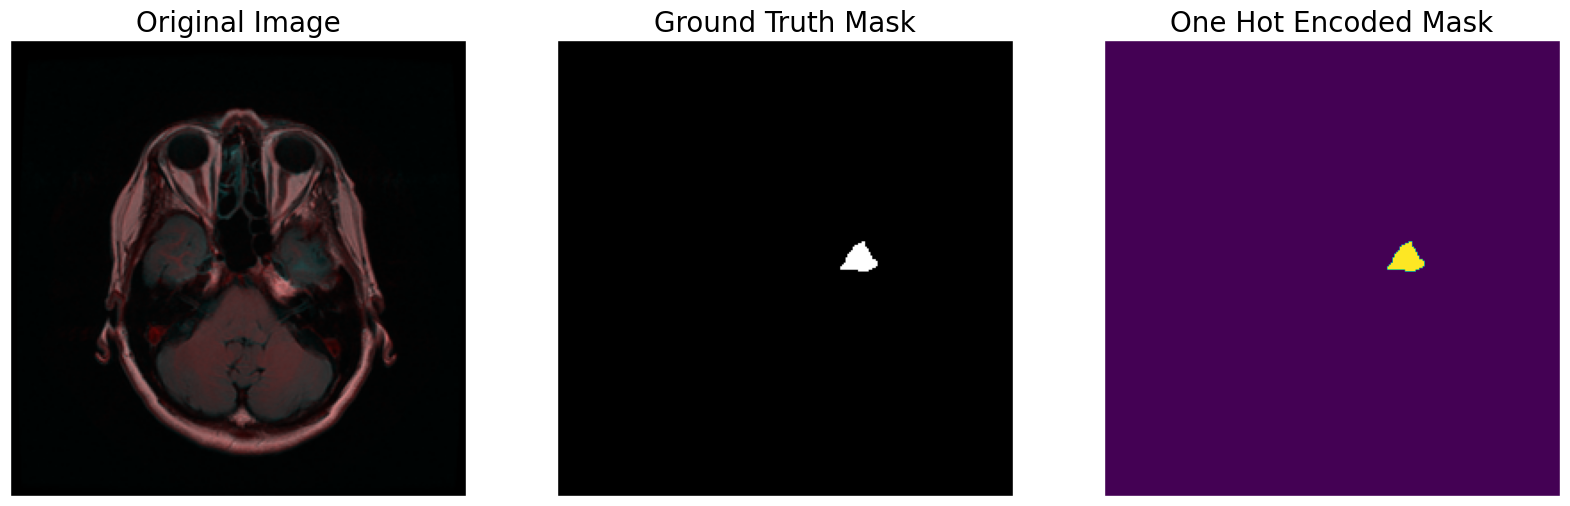

In [150]:
# Define the RGB values for the classes in the segmentation task
# two classes are defined: one for the background ([0, 0, 0] - black)
#and one for the segmentation target ([255, 255, 255] - white)
select_class_rgb_values = [[0, 0, 0], [255, 255, 255]]
dataset = LGGDataset(df_train, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset) - 1)
image, mask = dataset[random_idx]

plot_imgs(
    original_image=image,
    ground_truth_mask=colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask=reverse_one_hot(mask)
)

## Augmentations

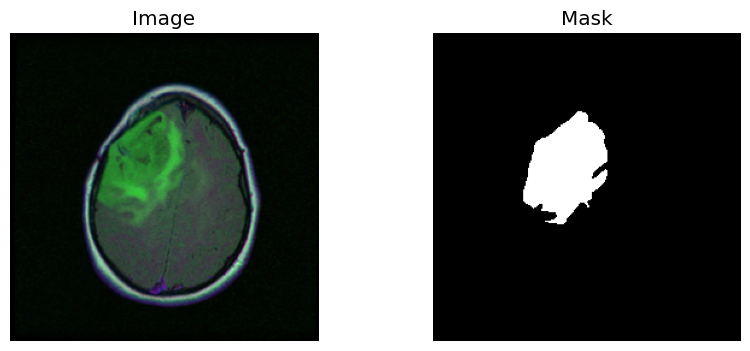

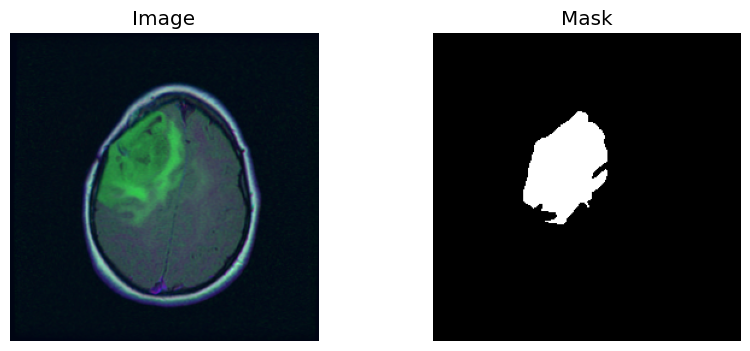

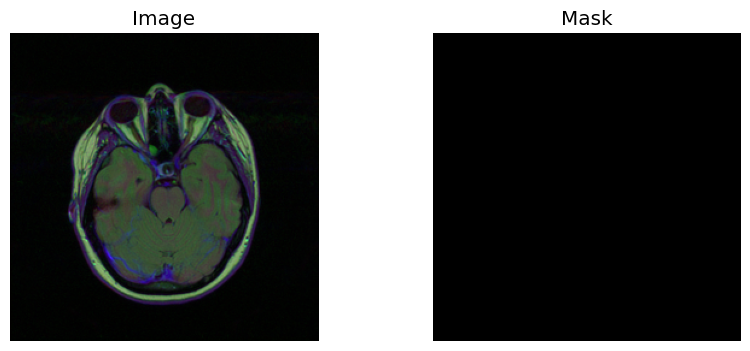

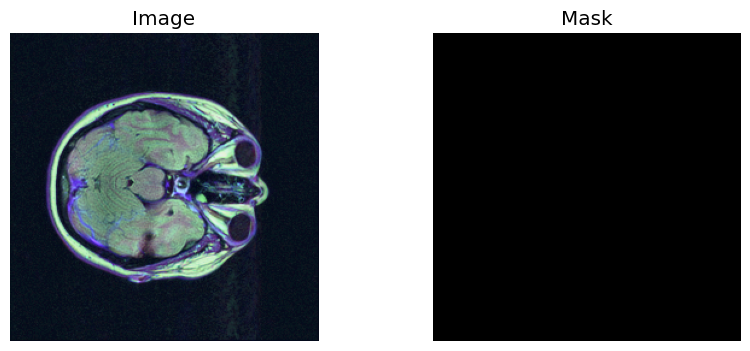

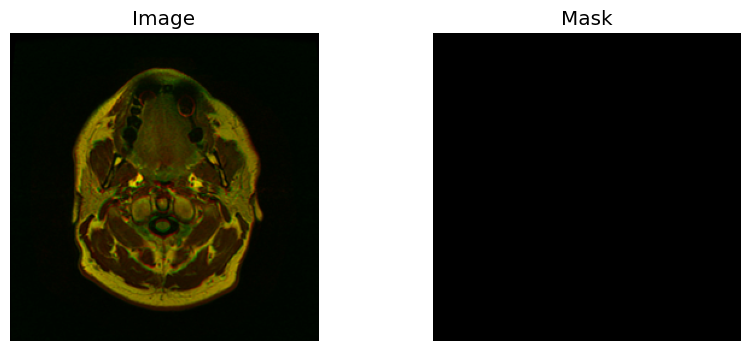

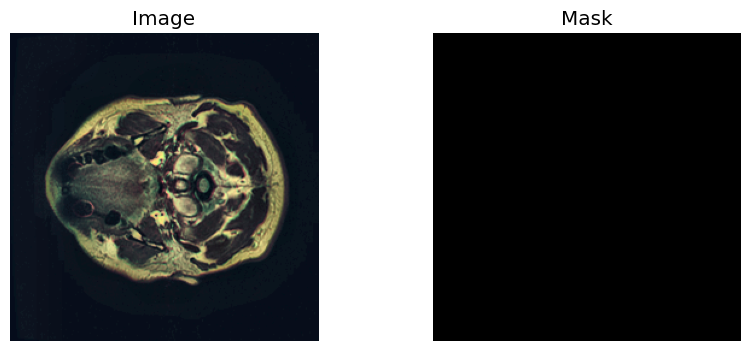

In [120]:
import albumentations as A

def training_augmentation():
    train_transform = [
        A.RandomCrop(height=256, width=256, always_apply=True), # Crops a random part of the input image to the specified height and width
        A.HorizontalFlip(p=0.8), # Flips the input image horizontally (left to right) with a probability of 0.8.
        A.VerticalFlip(p=0.8), # Flips the input image vertically (top to bottom) with a probability of 0.8.
        A.RandomRotate90(p=0.8), # Rotates the input image by 90 degrees either clockwise or counterclockwise with a probability of 0.8
        # A.OneOf([
        #     A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        #     A.GridDistortion(p=0.5),
        #     A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5)
        # ], p=0.7),
        A.CLAHE(p=0.5), # Enhances the contrast of the image by applying adaptive histogram equalization, which is particularly useful for improving the visibility of features in medical images
        A.RandomBrightnessContrast(p=0.5), # Randomly changes the brightness and contrast of the image with a probability of 0.5.
        A.RandomGamma(p=0.5), # Adjusts the gamma of the image, which can alter the luminance of the image, making it either darker or lighter
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # Scales the pixel values of the image to have a certain mean and standard deviation
    ]
    return A.Compose(train_transform) #applies sequentially to the input images and masks



select_class_rgb_values = [[0, 0, 0], [255, 255, 255]]
dataset = LGGDataset(df_train, class_rgb_values=select_class_rgb_values)

def draw_imgs(image, mask):
    plt.figure(figsize=(10, 4))
    # rescale the image to the range [0, 1] for floats
    display_image = np.copy(image)
    if image.max() > 1 or image.min() < 0:
        display_image = (display_image - display_image.min()) / (display_image.max() - display_image.min())
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(display_image)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Mask')

    display_mask = np.copy(mask)
    if display_mask.ndim == 3 and display_mask.shape[2] == 1:
        display_mask = display_mask.squeeze(axis=2)  # remove the channel dimension if it's 1
    elif display_mask.ndim == 3 and display_mask.shape[2] == 2:
        display_mask = display_mask[..., 1]  # select one channel if mask has an unexpected shape
    plt.imshow(display_mask, cmap='gray')
    plt.axis('off')
    plt.show()

#visualize 3 random samples with their original and augmented versions
for i in range(3):
    # get a random sample
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]

    augmentation = training_augmentation()
    augmented = augmentation(image=image, mask=mask)
    augmented_image = augmented['image']
    augmented_mask = augmented['mask']

    #original and augmented images and masks
    draw_imgs(image, mask)
    draw_imgs(augmented_image, augmented_mask)

In [121]:
import albumentations as A

def validation_augmentations():
    return A.Compose([
        #Ensures that the image has a minimum height and width of 256 pixels.
        #If the image is smaller than these dimensions, padding is added to reach the required size.
        #border_mode=0 specifies that the padding should be filled with a constant value of 0 (black).
        A.PadIfNeeded(min_height=256, min_width=256, always_apply=True, border_mode=0),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), always_apply=True),
    ])
    return A.Compose([padding_transform])

def convert_to_tensor(x, **kwargs):
    if x.ndim == 2:
        x = x[:, :, None]
    return x.transpose(2, 0, 1).astype('float32')

def apply_preprocessing(preprocessing_function=None):
    transformations = []
    if preprocessing_function:
        transformations.append(A.Lambda(image=preprocessing_function))
    transformations.append(A.Lambda(image=convert_to_tensor, mask=convert_to_tensor))
    return A.Compose(transformations)

## Models

## DEEPLABV3+

In [ ]:
import segmentation_models_pytorch.utils.metrics
from segmentation_models_pytorch import utils

In [ ]:
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = "imagenet"
CLASSES = ['Health_brain', 'Tumor']  # Binary classification (background and tumor)
ACTIVATION = 'sigmoid'  # sigmoid activation for binary classification

# Define auxiliary parameters for the model
aux_params = dict(
    pooling='avg',  # Type of pooling layer
    dropout=0.3,  # Dropout rate
    activation=ACTIVATION,  # Activation function
    classes=1,  # Number of output classes
)

common_params = {
    'encoder_name': ENCODER,
    'encoder_weights': ENCODER_WEIGHTS,
    'classes': 1,
    'activation': ACTIVATION,
    'aux_params': aux_params
}

models = {
    #'Unet': smp.Unet(**common_params),
    #'Unet++': smp.UnetPlusPlus(**common_params),
    #'MAnet': smp.MAnet(**common_params),
    #'Linknet': smp.Linknet(**common_params),
    #'FPN': smp.FPN(**common_params),
    #'PSPNet': smp.PSPNet(**common_params),
    #'PAN': smp.PAN(**common_params),
    #'DeepLabV3': smp.DeepLabV3(**common_params),
    'DeepLabV3+': smp.DeepLabV3Plus(**common_params),
}

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b5-b6417697.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b5-b6417697.pth
100%|██████████| 117M/117M [00:00<00:00, 274MB/s] 


In [ ]:
# Get the preprocessing function specific to the chosen encoder
preprocessing_function =  smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
# dataset initialization with one_hot_encode=False
train_dataset = LGGDataset(df_train, class_rgb_values=select_class_rgb_values, one_hot_encode=False,
    augmentation=training_augmentation(), preprocessing=apply_preprocessing(preprocessing_function))
valid_dataset = LGGDataset(df_val, class_rgb_values=select_class_rgb_values, one_hot_encode=False,
    augmentation=validation_augmentations(), preprocessing=apply_preprocessing(preprocessing_function))
test_dataset = LGGDataset(df_test, class_rgb_values=select_class_rgb_values, one_hot_encode=False,
    preprocessing=apply_preprocessing(preprocessing_function))  # No augmentation for test dataset
# Initialize DataLoaders for training, validation, and test datasets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=5)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=3)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=3)

In [ ]:
from segmentation_models_pytorch import utils
import torch
from tqdm.auto import tqdm

def train_and_validate(model, model_name, train_loader, valid_loader, optimizer, loss_fn, metrics, device, epochs):
    best_iou_score = 0.0
    train_losses = []
    valid_losses = []
    iou_scores = []
    f_scores = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)
        for images, targets in train_iterator:
            images, targets = images.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            # If the model returns a tuple (as in some smp models), use the first element as the output
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_iterator.set_postfix(loss=loss.item())# Update the progress bar with the current loss

        model.eval()
        valid_loss = 0.0
        iou_scores_epoch = []
        f_scores_epoch = []

        iou_metric = smp.utils.metrics.IoU(threshold=0.55)

        valid_iterator = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{epochs} [Valid]", leave=False)
        with torch.no_grad():
            for images, targets in valid_iterator:
                images, targets = images.to(device), targets.to(device)
                outputs = model(images)

                # If the model returns a tuple (as in some smp models), use the first element as the output
                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                loss = loss_fn(outputs, targets)
                valid_loss += loss.item()

                # Compute IoU score for each batch
                iou_score_batch = iou_metric(outputs, targets).item()
                iou_scores_epoch.append(iou_score_batch)

                outputs = torch.sigmoid(outputs)
                outputs = (outputs > 0.55).float()

                # tp = (outputs * targets).sum().item()
                # fp = ((outputs == 1) & (targets == 0)).sum().item()
                # fn = ((outputs == 0) & (targets == 1)).sum().item()
                # precision = tp / (tp + fp) if (tp + fp) > 0 else 0
                # recall = tp / (tp + fn) if (tp + fn) > 0 else 0
                # f1_score_batch = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
                # f_scores_epoch.append(f1_score_batch)

        avg_train_loss = train_loss / len(train_loader)
        avg_valid_loss = valid_loss / len(valid_loader)
        avg_iou_score = sum(iou_scores_epoch) / len(iou_scores_epoch)
        #avg_f1_score = sum(f_scores_epoch) / len(f_scores_epoch)

        train_losses.append(avg_train_loss)
        valid_losses.append(avg_valid_loss)
        iou_scores.append(avg_iou_score)
        #f_scores.append(avg_f1_score)

        tqdm.write(f'\nEpoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}, IoU: {avg_iou_score:.4f}')

        if avg_iou_score > best_iou_score:
            best_iou_score = avg_iou_score
            model_save_path = f'/content/{model_name}_best.pth'
            torch.save(model.state_dict(), model_save_path)
            tqdm.write(f'Model saved to {model_save_path} with IoU: {best_iou_score:.4f}')

    # Plotting the training and validation losses, IoU, and F-scores
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, valid_losses, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, iou_scores, label='IoU Score')
    #plt.plot(epochs_range, f_scores, label='F1 Score')
    plt.legend(loc='upper left')
    plt.title('IoU')
    plt.show()

    return best_iou_score


In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Define a custom loss class that combines Dice loss and BCE loss
class CombinedLoss(nn.Module):
    def __init__(self):
        super(CombinedLoss, self).__init__()
        self.dice_loss = smp.utils.losses.DiceLoss() # Initialize Dice loss
        self.bce_loss = nn.BCEWithLogitsLoss()  # Initialize BCE loss with logits
        self.__name__ = 'combined_loss'

    def forward(self, inputs, targets):
        if isinstance(inputs, tuple):
            inputs_main = inputs[0]
        else:
            inputs_main = inputs

        dice = self.dice_loss(torch.sigmoid(inputs_main), targets)  #sigmoid for DiceLoss
        bce = self.bce_loss(inputs_main, targets)  # BCEWithLogitsLoss applies sigmoid internally
        return dice + bce

Training and validating model: DeepLabV3+


Epoch 1/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 1/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 1, Train Loss: 1.6686, Valid Loss: 1.6698, IoU: 0.8081
Model saved to /content/DeepLabV3+_best.pth with IoU: 0.8081


Epoch 2/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 2/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 2, Train Loss: 1.6662, Valid Loss: 1.6687, IoU: 0.8206
Model saved to /content/DeepLabV3+_best.pth with IoU: 0.8206


Epoch 3/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 3/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 3, Train Loss: 1.6650, Valid Loss: 1.6677, IoU: 0.8414
Model saved to /content/DeepLabV3+_best.pth with IoU: 0.8414


Epoch 4/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 4/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 4, Train Loss: 1.6643, Valid Loss: 1.6670, IoU: 0.8548
Model saved to /content/DeepLabV3+_best.pth with IoU: 0.8548


Epoch 5/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 5/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 5, Train Loss: 1.6639, Valid Loss: 1.6666, IoU: 0.8660
Model saved to /content/DeepLabV3+_best.pth with IoU: 0.8660


Epoch 6/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 6/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 6, Train Loss: 1.6635, Valid Loss: 1.6669, IoU: 0.8562


Epoch 7/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 7/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 7, Train Loss: 1.6634, Valid Loss: 1.6662, IoU: 0.8741
Model saved to /content/DeepLabV3+_best.pth with IoU: 0.8741


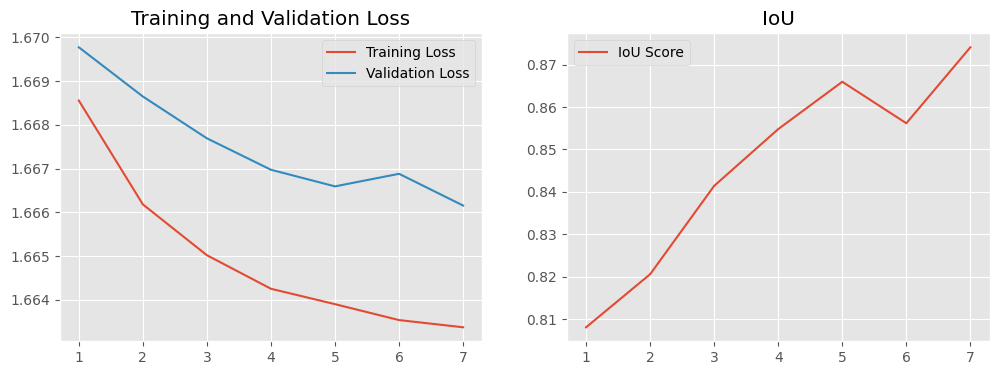

The best model is DeepLabV3+ with an IoU score of 0.874088361063931


In [ ]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import gc

model_scores = {}
EPOCHS = 7
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


loss = CombinedLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.55)]

torch.cuda.empty_cache()
gc.collect()

for model_name, model in models.items():
    print(f"Training and validating model: {model_name}")
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    #lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)
    best_iou_score = train_and_validate(model, model_name, train_loader, valid_loader, optimizer, loss, metrics, DEVICE, EPOCHS)
    model_scores[model_name] = best_iou_score

best_model_name = max(model_scores, key=model_scores.get)
print(f"The best model is {best_model_name} with an IoU score of {model_scores[best_model_name]}")

In [ ]:
models = {
    #'Unet': smp.Unet(**common_params),
    #'Unet++': smp.UnetPlusPlus(**common_params),
    #'MAnet': smp.MAnet(**common_params),
    #'Linknet': smp.Linknet(**common_params),
    #'FPN': smp.FPN(**common_params),
    #'PSPNet': smp.PSPNet(**common_params),
    #'PAN': smp.PAN(**common_params),
    #'DeepLabV3': smp.DeepLabV3(**common_params),
    'DeepLabV3+': smp.DeepLabV3Plus(**common_params),
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader, device, metrics):
    model.eval()
    metric_scores = {metric.__name__: [] for metric in metrics}
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            for metric in metrics:
                score = metric(outputs, targets)
                metric_scores[metric.__name__].append(score.item())

    avg_metric_scores = {metric: sum(scores) / len(scores) for metric, scores in metric_scores.items()}
    return avg_metric_scores


model_eval_scores = {}
for model_name, model in models.items():

    weight_path = f'/content/{model_name}_best.pth'
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model = model.to(device)

    avg_metric_scores = evaluate_model(model, test_loader, device, metrics)
    model_eval_scores[model_name] = avg_metric_scores

    print(f"Model: {model_name}")
    for metric_name, avg_score in avg_metric_scores.items():
        print(f'{metric_name}: {avg_score:.4f}')

Evaluating:   0%|          | 0/393 [00:00<?, ?it/s]

Model: DeepLabV3+
iou_score: 0.8739


In [ ]:
model = smp.DeepLabV3Plus(**common_params)
model_path = '/content/DeepLabV3+_best.pth'
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model = model.to(DEVICE)

## Draw predictions

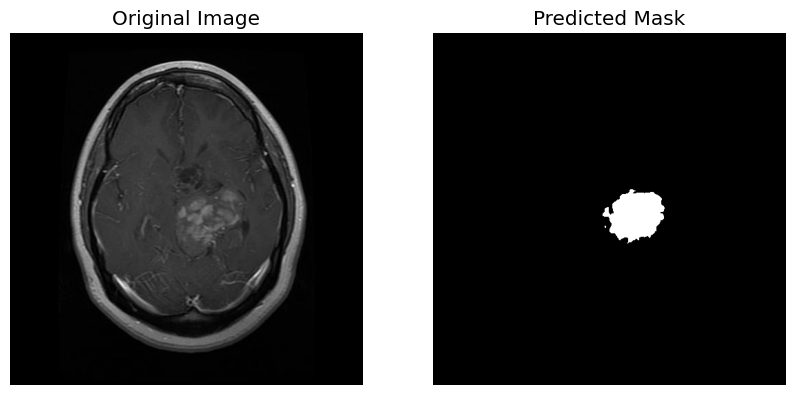

In [ ]:
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=MEAN, std=STD)
])


img_path = "/content/glioma_tumor.jpg"
img = Image.open(img_path).convert('RGB')
input_image = transform(img)
input_image = input_image.unsqueeze(0).to(DEVICE)  # Add batch dimension and send to device

model.eval()
with torch.no_grad():
    output = model(input_image)
    if isinstance(output, tuple):
        output = output[0]
    prediction = torch.sigmoid(output)
    predicted_mask = (prediction > 0.55).float()


plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

# Predicted Mask
plt.subplot(1, 2, 2)
predicted_mask_np = predicted_mask.cpu().squeeze().numpy()
plt.imshow(predicted_mask_np, cmap='gray', vmin=0, vmax=1)
plt.title('Predicted Mask')
plt.axis('off')

plt.show()

[[0.5005417  0.5004587  0.50038844 ... 0.50050575 0.50056475 0.50063056]
 [0.50039417 0.50032586 0.5002693  ... 0.50034386 0.50039554 0.5004549 ]
 [0.50028676 0.50023144 0.50018674 ... 0.50023377 0.500277   0.5003282 ]
 ...
 [0.5005994  0.50047004 0.5003686  ... 0.5003242  0.50040114 0.5004964 ]
 [0.5008303  0.50062823 0.5004753  ... 0.50036025 0.5004278  0.5005079 ]
 [0.5011498  0.50083953 0.5006128  ... 0.5004004  0.5004561  0.5005196 ]]


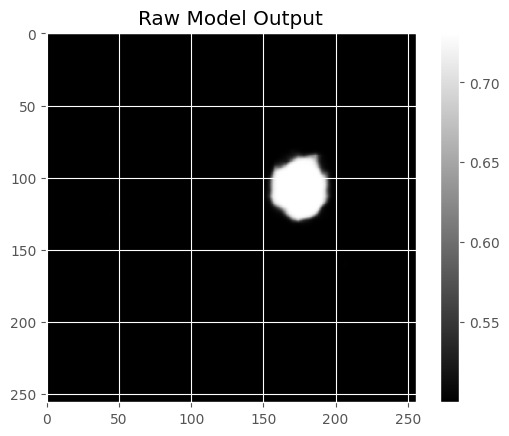

In [ ]:
input_image, _ = test_dataset[5]
input_image = torch.from_numpy(input_image) if isinstance(input_image, np.ndarray) else input_image
input_image = input_image.unsqueeze(0).to(DEVICE)
model.eval()
with torch.no_grad():
    input_image = torch.from_numpy(input_image) if isinstance(input_image, np.ndarray) else input_image
    output = model(input_image)
    if isinstance(output, tuple):
        output = output[0]
    output = torch.sigmoid(output)
    output = output.cpu().squeeze().numpy()
    print(output)

plt.imshow(output, cmap='gray')
plt.title('Raw Model Output')
plt.colorbar()
plt.show()

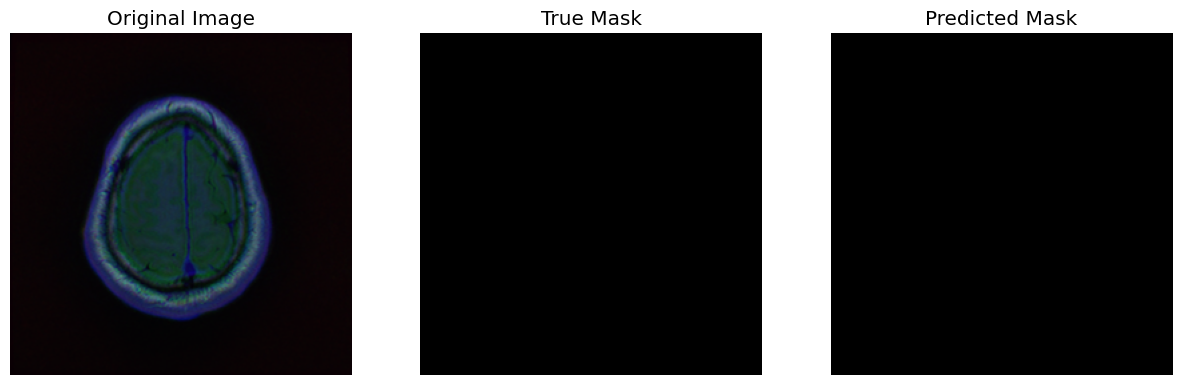

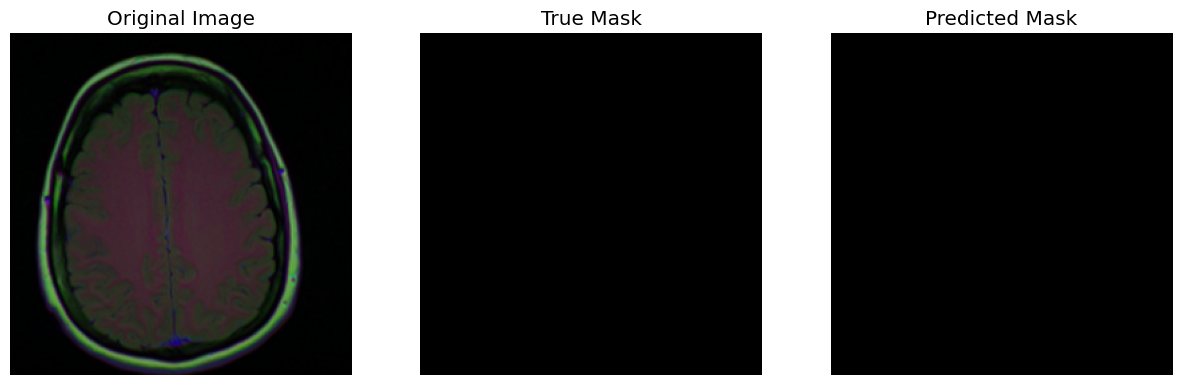

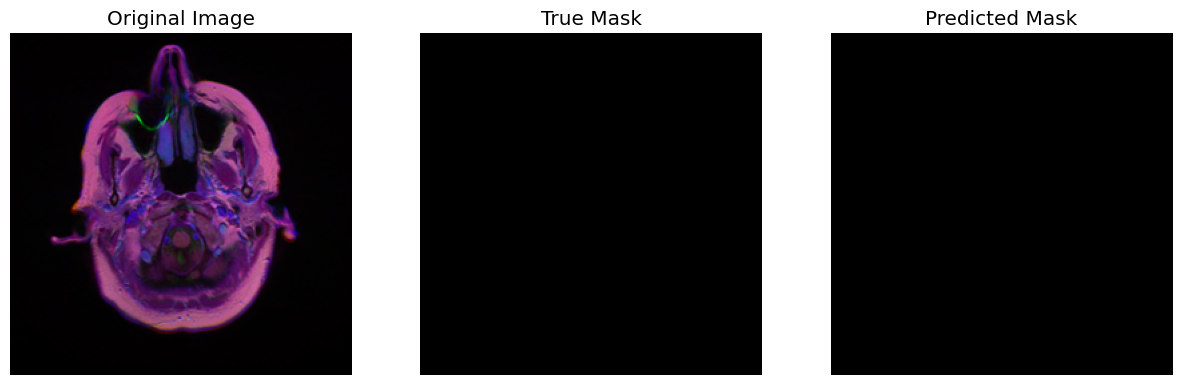

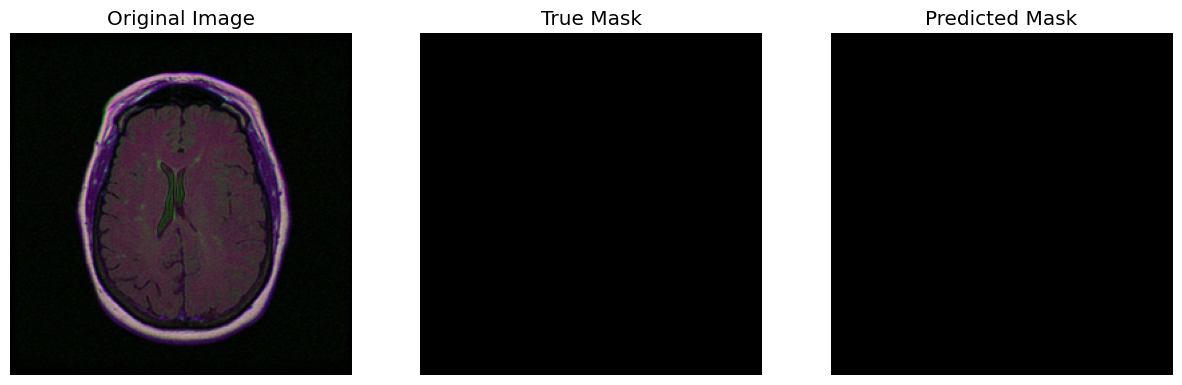

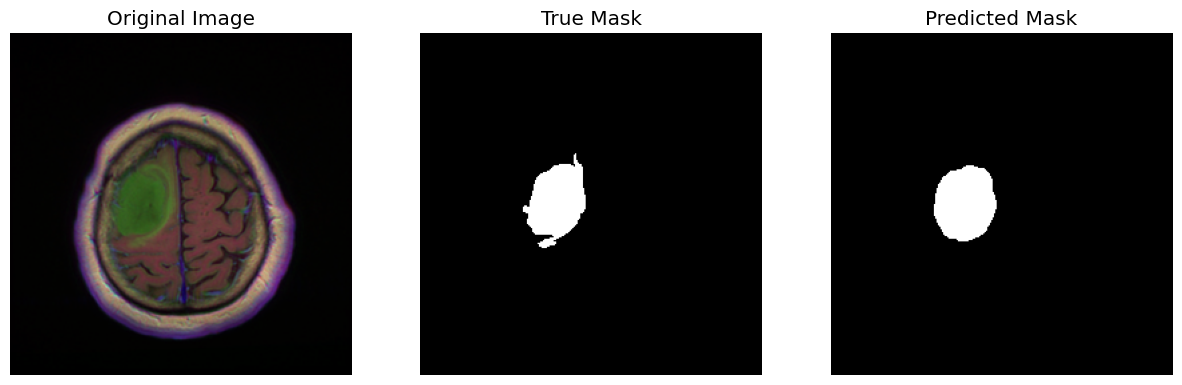

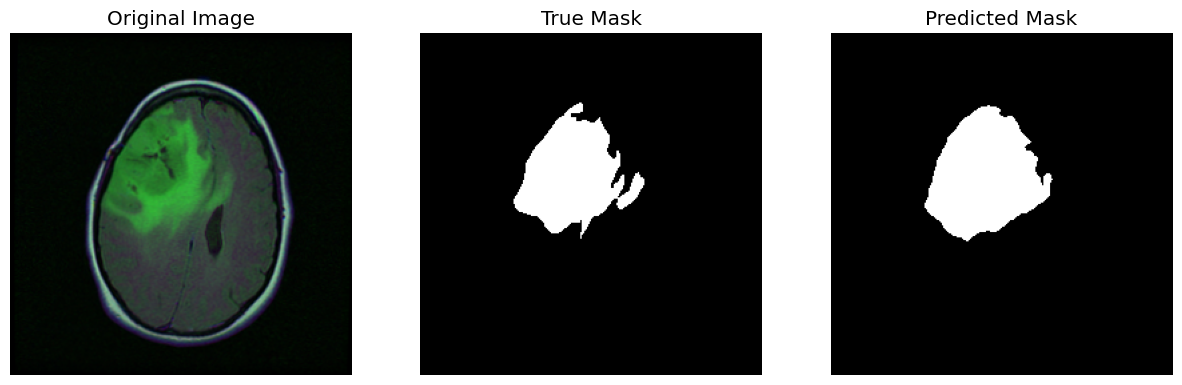

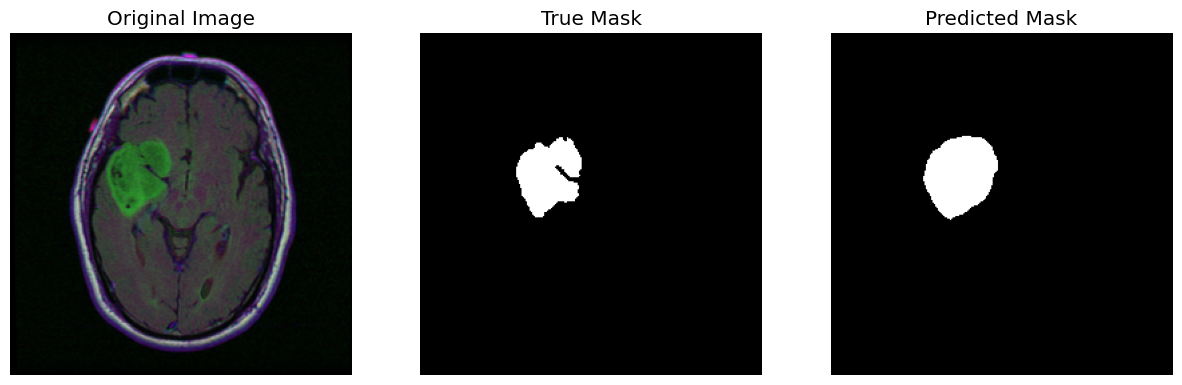

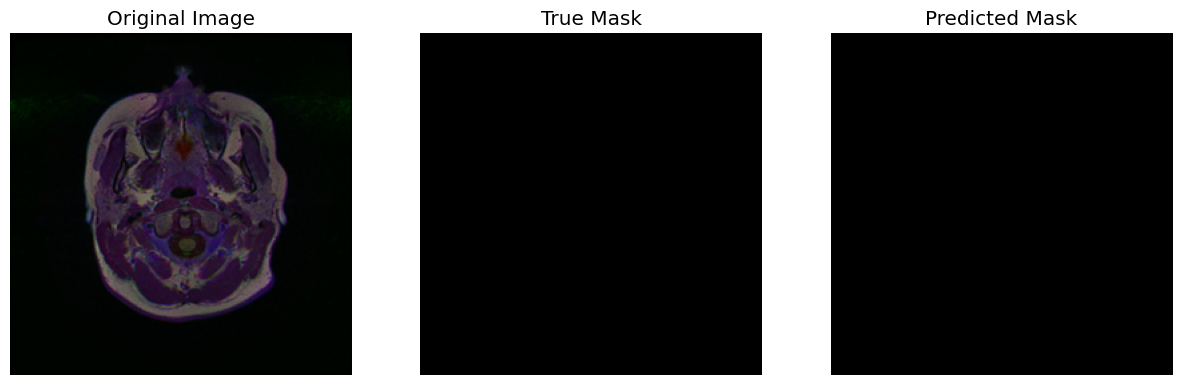

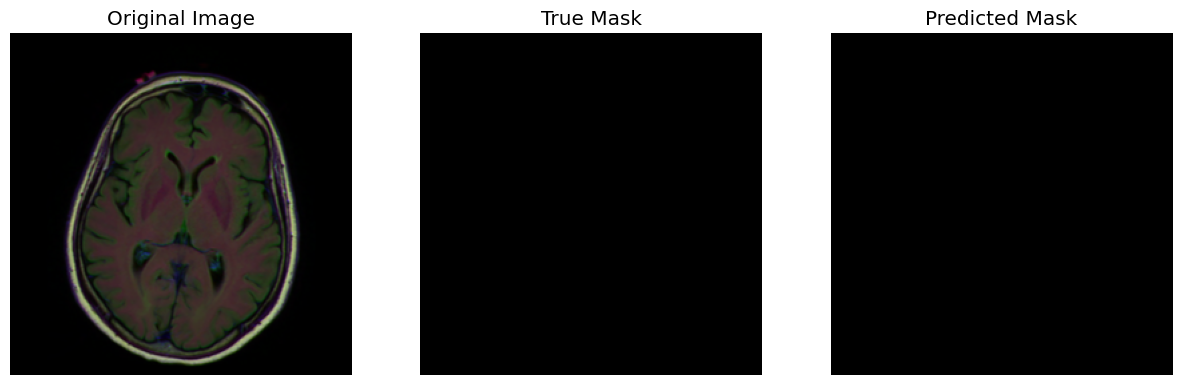

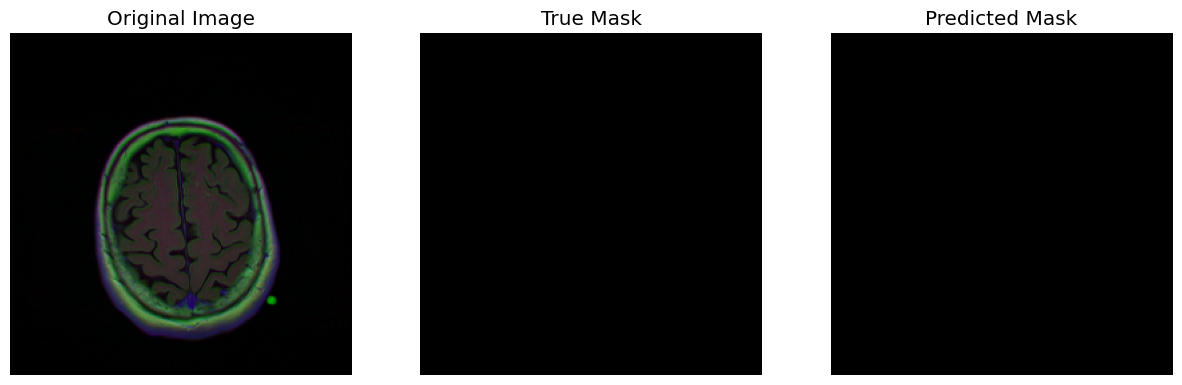

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import random

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

def denormalize(image):
    # Ensure image is in the shape (channels, height, width)
    if image.ndim == 3 and image.shape[-1] == 3:
        image = image.transpose(2, 0, 1)
    # Reverse the normalization process
    image = (image * STD[:, None, None]) + MEAN[:, None, None]
    # Ensure image is in the shape (height, width, channels) for visualization
    if image.ndim == 3:
        image = image.transpose(1, 2, 0)
    # Clip values to ensure they are between 0 and 1, as imshow expects
    image = np.clip(image, 0, 1)
    return image

def visualize_random_predictions(model, dataset, device, num_images=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)

    with torch.no_grad():
        for idx in indices:
            image, mask = dataset[idx]
            image = torch.from_numpy(image) if isinstance(image, np.ndarray) else image
            mask = torch.from_numpy(mask) if isinstance(mask, np.ndarray) else mask
            image = image.unsqueeze(0).to(device)
            mask = mask.unsqueeze(0).to(device)

            outputs = model(image)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            predictions = torch.sigmoid(outputs)
            predicted_masks = (predictions > 0.55).float()

            plt.figure(figsize=(15, 5))

            # Original Image (denormalized)
            image_np = image[0].cpu().numpy()
            image_denorm = denormalize(image_np)
            plt.subplot(1, 3, 1)
            plt.imshow(image_denorm)
            plt.title('Original Image')
            plt.axis('off')

            # True Mask
            plt.subplot(1, 3, 2)
            plt.imshow(mask[0].cpu().squeeze(), cmap='gray')
            plt.title('True Mask')
            plt.axis('off')

            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(predicted_masks[0].cpu().squeeze(), cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')

            plt.show()

visualize_random_predictions(model, test_dataset, device, num_images=10)

## UNET++

In [ ]:
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = "imagenet"
CLASSES = ['Health_brain', 'Tumor']  # Binary classification (background and tumor)
ACTIVATION = 'sigmoid'  # sigmoid activation for binary classification

aux_params = dict(
    pooling='avg',
    dropout=0.3,
    activation=ACTIVATION,
    classes=1,
)

common_params = {
    'encoder_name': ENCODER,
    'encoder_weights': ENCODER_WEIGHTS,
    'classes': 1,
    'activation': ACTIVATION,
    'aux_params': aux_params
}

models = {
    #'Unet': smp.Unet(**common_params),
    'Unet++': smp.UnetPlusPlus(**common_params),
    #'MAnet': smp.MAnet(**common_params),
    #'Linknet': smp.Linknet(**common_params),
    #'FPN': smp.FPN(**common_params),
    #'PSPNet': smp.PSPNet(**common_params),
    #'PAN': smp.PAN(**common_params),
    #'DeepLabV3': smp.DeepLabV3(**common_params),
    #'DeepLabV3+': smp.DeepLabV3Plus(**common_params),
}

Training and validating model: Unet++


Epoch 1/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 1/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 1, Train Loss: 1.8502, Valid Loss: 1.7714, IoU: 0.0908
Model saved to /content/Unet++_best.pth with IoU: 0.0908


Epoch 2/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 2/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 2, Train Loss: 1.7388, Valid Loss: 1.7194, IoU: 0.7734
Model saved to /content/Unet++_best.pth with IoU: 0.7734


Epoch 3/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 3/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 3, Train Loss: 1.7058, Valid Loss: 1.6999, IoU: 0.8297
Model saved to /content/Unet++_best.pth with IoU: 0.8297


Epoch 4/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 4/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 4, Train Loss: 1.6907, Valid Loss: 1.6886, IoU: 0.8418
Model saved to /content/Unet++_best.pth with IoU: 0.8418


Epoch 5/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 5/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 5, Train Loss: 1.6821, Valid Loss: 1.6815, IoU: 0.8575
Model saved to /content/Unet++_best.pth with IoU: 0.8575


Epoch 6/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 6/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 6, Train Loss: 1.6765, Valid Loss: 1.6776, IoU: 0.8423


Epoch 7/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 7/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 7, Train Loss: 1.6730, Valid Loss: 1.6750, IoU: 0.8544


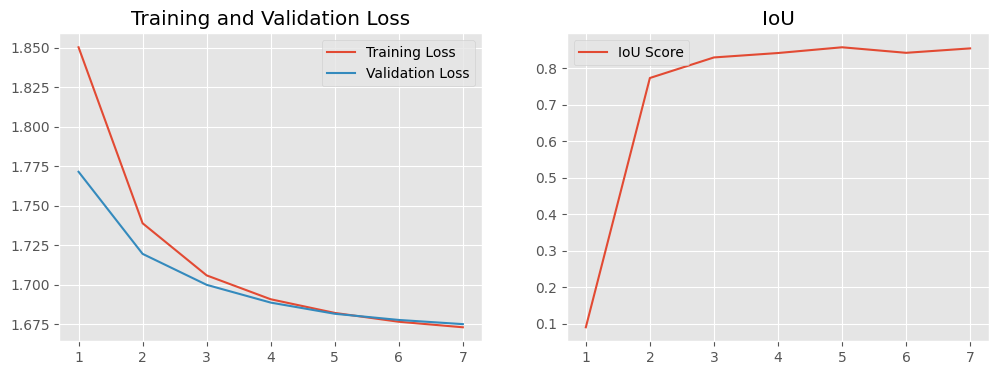

In [ ]:
import gc
model_scores = {}
EPOCHS = 7
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = CombinedLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
torch.cuda.empty_cache()
gc.collect()

for model_name, model in models.items():
    print(f"Training and validating model: {model_name}")
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    best_iou_score = train_and_validate(model, model_name, train_loader, valid_loader, optimizer, loss, metrics, DEVICE, EPOCHS)
    model_scores[model_name] = best_iou_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader, device, metrics):
    model.eval()
    metric_scores = {metric.__name__: [] for metric in metrics}
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            for metric in metrics:
                score = metric(outputs, targets)
                metric_scores[metric.__name__].append(score.item())

    avg_metric_scores = {metric: sum(scores) / len(scores) for metric, scores in metric_scores.items()}
    return avg_metric_scores


model_eval_scores = {}
for model_name, model in models.items():

    weight_path = f'/content/{model_name}_best.pth'
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model = model.to(device)

    avg_metric_scores = evaluate_model(model, test_loader, device, metrics)
    model_eval_scores[model_name] = avg_metric_scores

    print(f"Model: {model_name}")
    for metric_name, avg_score in avg_metric_scores.items():
        print(f'{metric_name}: {avg_score:.4f}')

Evaluating:   0%|          | 0/393 [00:00<?, ?it/s]

Model: Unet++
iou_score: 0.8268


In [ ]:
model = smp.UnetPlusPlus(**common_params)
model_path = '/content/Unet++_best.pth'
model.load_state_dict(torch.load(model_path, map_location=DEVICE))
model = model.to(DEVICE)

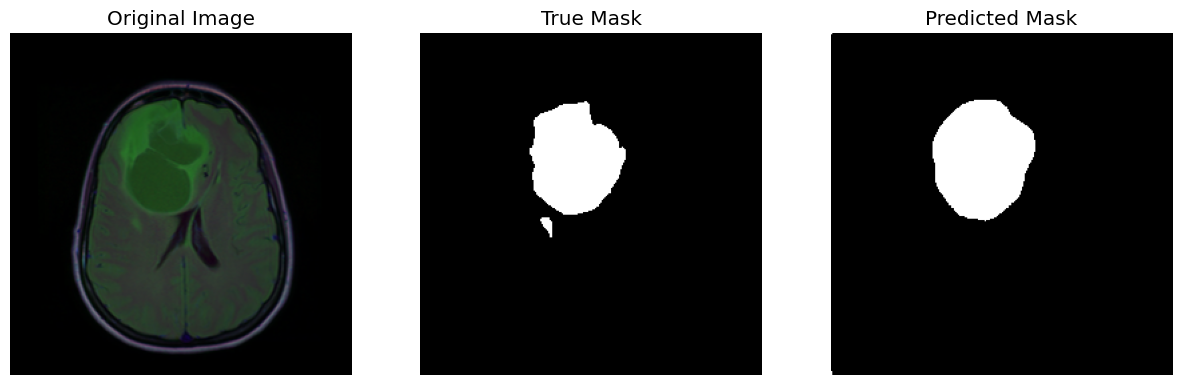

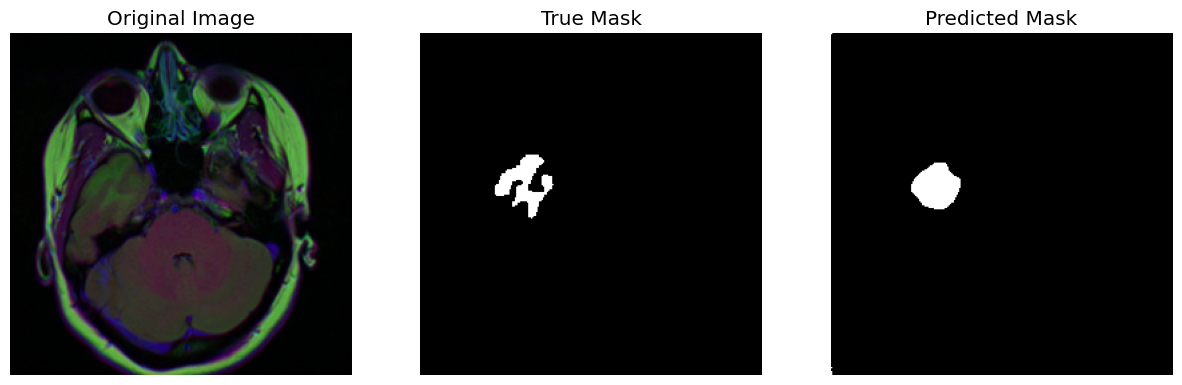

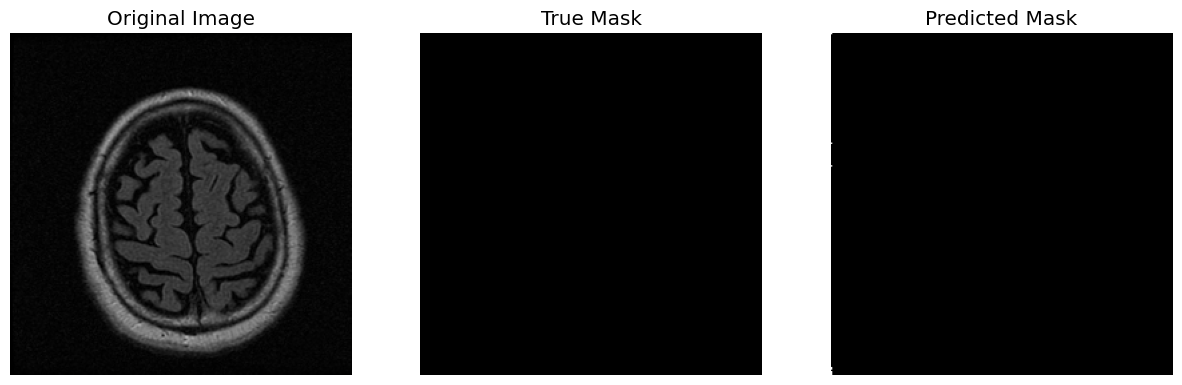

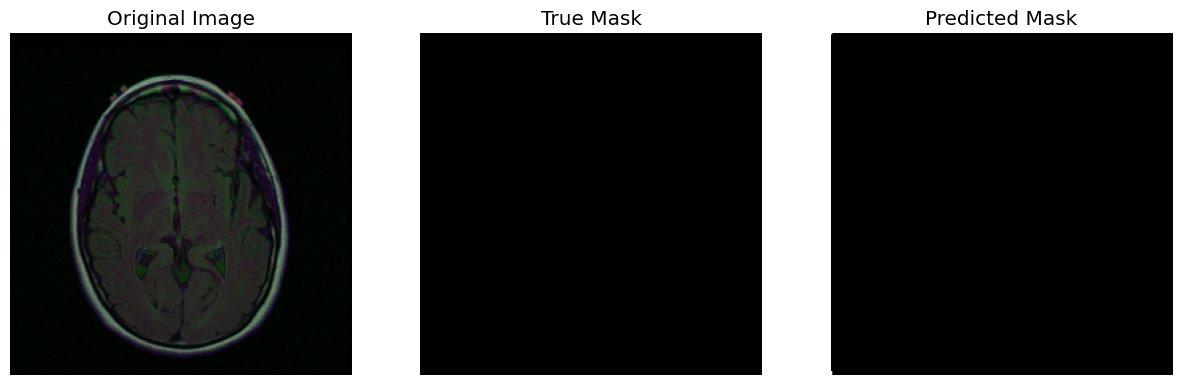

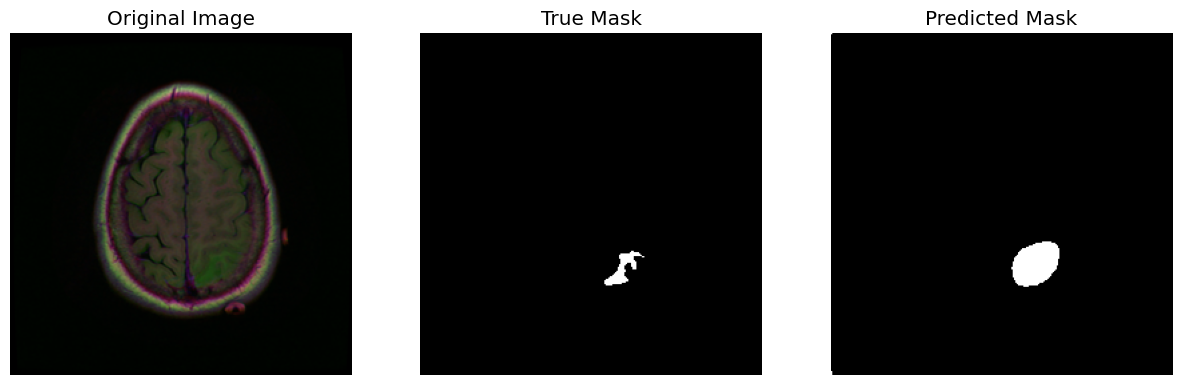

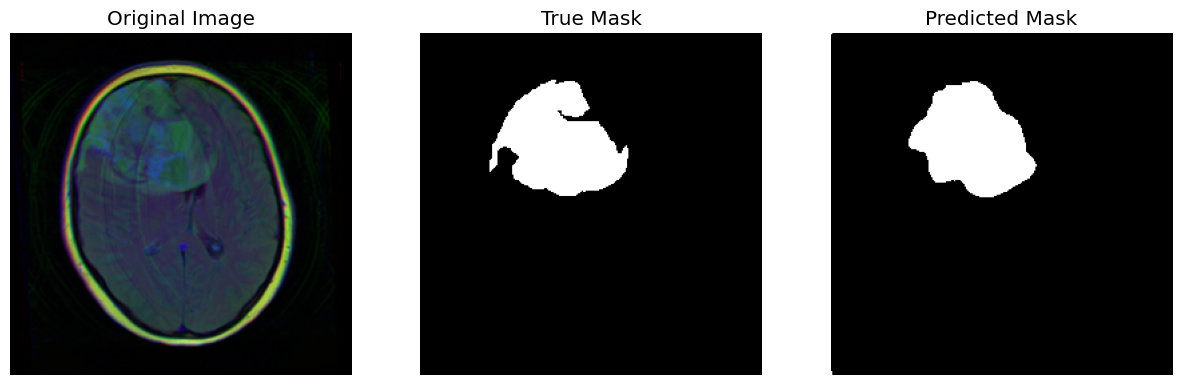

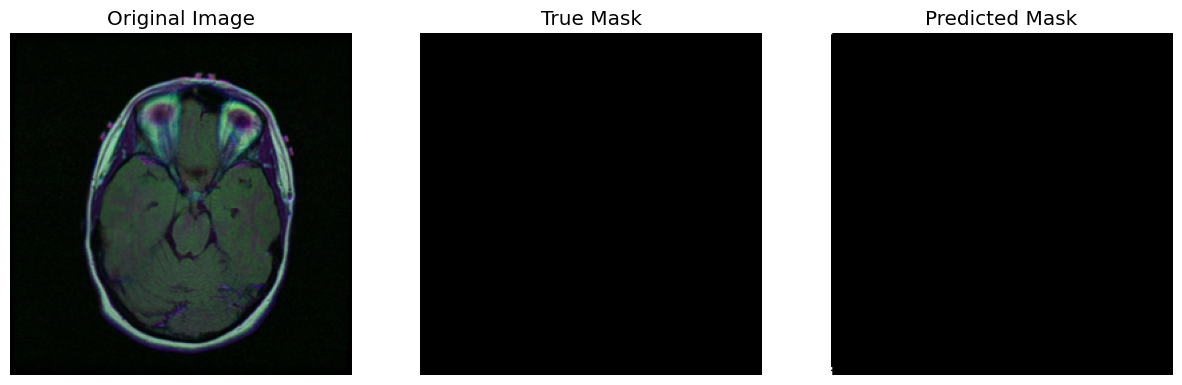

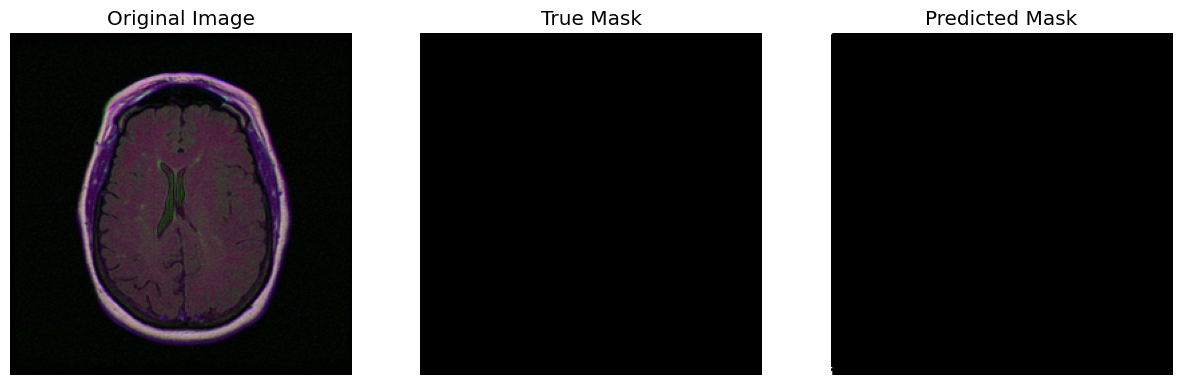

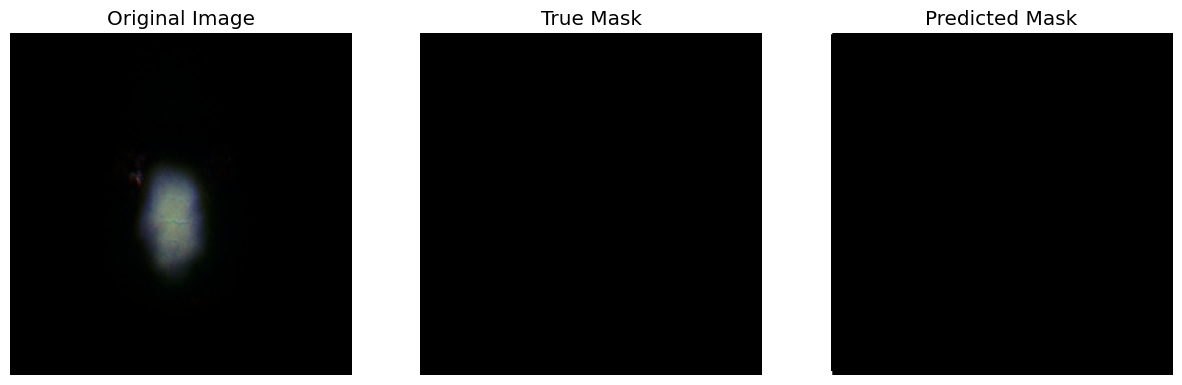

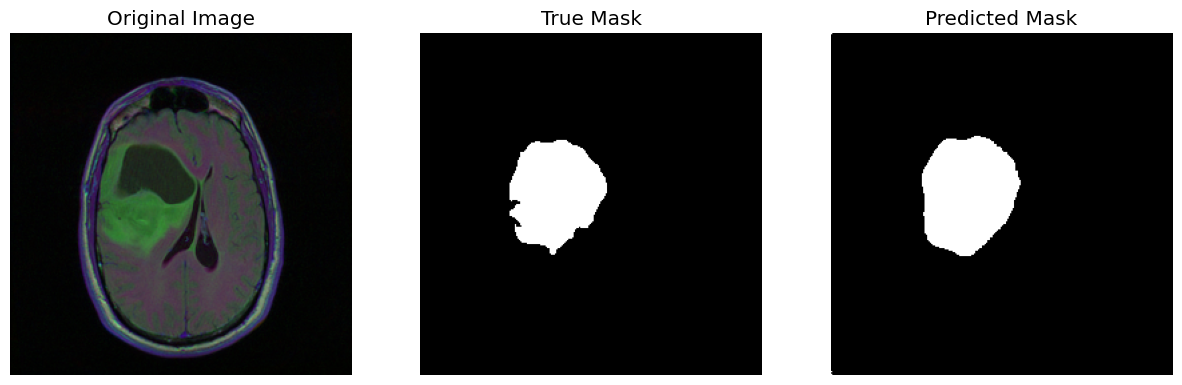

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
import random

MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

def denormalize(image):
    if image.ndim == 3 and image.shape[-1] == 3:
        image = image.transpose(2, 0, 1)
    image = (image * STD[:, None, None]) + MEAN[:, None, None]
    if image.ndim == 3:
        image = image.transpose(1, 2, 0)
    image = np.clip(image, 0, 1)
    return image

def visualize_random_predictions(model, dataset, device, num_images=3):
    model.eval()
    indices = random.sample(range(len(dataset)), num_images)

    with torch.no_grad():
        for idx in indices:
            image, mask = dataset[idx]
            image = torch.from_numpy(image) if isinstance(image, np.ndarray) else image
            mask = torch.from_numpy(mask) if isinstance(mask, np.ndarray) else mask
            image = image.unsqueeze(0).to(device)
            mask = mask.unsqueeze(0).to(device)

            outputs = model(image)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            predictions = torch.sigmoid(outputs)
            predicted_masks = (predictions > 0.55).float()

            plt.figure(figsize=(15, 5))

            # Original Image (denormalized)
            image_np = image[0].cpu().numpy()
            image_denorm = denormalize(image_np)
            plt.subplot(1, 3, 1)
            plt.imshow(image_denorm)
            plt.title('Original Image')
            plt.axis('off')

            # True Mask
            plt.subplot(1, 3, 2)
            plt.imshow(mask[0].cpu().squeeze(), cmap='gray')
            plt.title('True Mask')
            plt.axis('off')

            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(predicted_masks[0].cpu().squeeze(), cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')

            plt.show()

visualize_random_predictions(model, test_dataset, device, num_images=10)

##PAN

In [ ]:
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = "imagenet"
CLASSES = ['Health_brain', 'Tumor']  # Binary classification (background and tumor)
ACTIVATION = 'sigmoid'  # sigmoid activation for binary classification

aux_params = dict(
    pooling='avg',
    dropout=0.3,
    activation=ACTIVATION,
    classes=1,
)

common_params = {
    'encoder_name': ENCODER,
    'encoder_weights': ENCODER_WEIGHTS,
    'classes': 1,
    'activation': ACTIVATION,
    'aux_params': aux_params
}

models = {
    #'Unet': smp.Unet(**common_params),
    #'Unet++': smp.UnetPlusPlus(**common_params),
    #'MAnet': smp.MAnet(**common_params),
    #'Linknet': smp.Linknet(**common_params),
    #'FPN': smp.FPN(**common_params),
    #'PSPNet': smp.PSPNet(**common_params),
    'PAN': smp.PAN(**common_params),
    #'DeepLabV3': smp.DeepLabV3(**common_params),
    #'DeepLabV3+': smp.DeepLabV3Plus(**common_params),
}

Training and validating model: PAN


Epoch 1/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 1/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 1, Train Loss: 1.7803, Valid Loss: 1.6906, IoU: 0.1836
Model saved to /content/PAN_best.pth with IoU: 0.1836


Epoch 2/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 2/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 2, Train Loss: 1.6768, Valid Loss: 1.6785, IoU: 0.6770
Model saved to /content/PAN_best.pth with IoU: 0.6770


Epoch 3/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 3/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 3, Train Loss: 1.6734, Valid Loss: 1.6725, IoU: 0.7572
Model saved to /content/PAN_best.pth with IoU: 0.7572


Epoch 4/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 4/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 4, Train Loss: 1.6691, Valid Loss: 1.6708, IoU: 0.7814
Model saved to /content/PAN_best.pth with IoU: 0.7814


Epoch 5/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 5/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 5, Train Loss: 1.6673, Valid Loss: 1.6696, IoU: 0.7885
Model saved to /content/PAN_best.pth with IoU: 0.7885


Epoch 6/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 6/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 6, Train Loss: 1.6666, Valid Loss: 1.6691, IoU: 0.8003
Model saved to /content/PAN_best.pth with IoU: 0.8003


Epoch 7/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 7/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 7, Train Loss: 1.6656, Valid Loss: 1.6683, IoU: 0.8058
Model saved to /content/PAN_best.pth with IoU: 0.8058


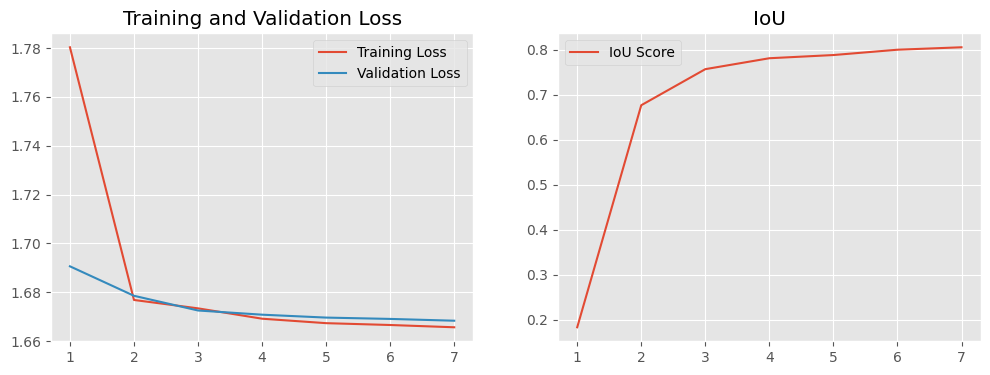

In [ ]:
import gc
model_scores = {}
EPOCHS = 7
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = CombinedLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
torch.cuda.empty_cache()
gc.collect()

for model_name, model in models.items():
    print(f"Training and validating model: {model_name}")
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    best_iou_score = train_and_validate(model, model_name, train_loader, valid_loader, optimizer, loss, metrics, DEVICE, EPOCHS)
    model_scores[model_name] = best_iou_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader, device, metrics):
    model.eval()
    metric_scores = {metric.__name__: [] for metric in metrics}
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            for metric in metrics:
                score = metric(outputs, targets)
                metric_scores[metric.__name__].append(score.item())

    avg_metric_scores = {metric: sum(scores) / len(scores) for metric, scores in metric_scores.items()}
    return avg_metric_scores


model_eval_scores = {}
for model_name, model in models.items():

    weight_path = f'/content/{model_name}_best.pth'
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model = model.to(device)

    avg_metric_scores = evaluate_model(model, test_loader, device, metrics)
    model_eval_scores[model_name] = avg_metric_scores

    print(f"Model: {model_name}")
    for metric_name, avg_score in avg_metric_scores.items():
        print(f'{metric_name}: {avg_score:.4f}')

Evaluating:   0%|          | 0/393 [00:00<?, ?it/s]

Model: PAN
iou_score: 0.7970


## UNET

In [ ]:
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = "imagenet"
CLASSES = ['Health_brain', 'Tumor']  # Binary classification (background and tumor)
ACTIVATION = 'sigmoid'  # sigmoid activation for binary classification

aux_params = dict(
    pooling='avg',
    dropout=0.3,
    activation=ACTIVATION,
    classes=1,
)

common_params = {
    'encoder_name': ENCODER,
    'encoder_weights': ENCODER_WEIGHTS,
    'classes': 1,
    'activation': ACTIVATION,
    'aux_params': aux_params
}

models = {
    'Unet': smp.Unet(**common_params),
    #'Unet++': smp.UnetPlusPlus(**common_params),
    #'MAnet': smp.MAnet(**common_params),
    #'Linknet': smp.Linknet(**common_params),
    #'FPN': smp.FPN(**common_params),
    #'PSPNet': smp.PSPNet(**common_params),
    #'PAN': smp.PAN(**common_params),
    #'DeepLabV3': smp.DeepLabV3(**common_params),
    #'DeepLabV3+': smp.DeepLabV3Plus(**common_params),
}

Training and validating model: Unet


Epoch 1/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 1/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 1, Train Loss: 1.8029, Valid Loss: 1.7525, IoU: 0.5425
Model saved to /content/Unet_best.pth with IoU: 0.5425


Epoch 2/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 2/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 2, Train Loss: 1.7204, Valid Loss: 1.7108, IoU: 0.7684
Model saved to /content/Unet_best.pth with IoU: 0.7684


Epoch 3/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 3/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 3, Train Loss: 1.6947, Valid Loss: 1.6905, IoU: 0.8385
Model saved to /content/Unet_best.pth with IoU: 0.8385


Epoch 4/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 4/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 4, Train Loss: 1.6822, Valid Loss: 1.6816, IoU: 0.8385
Model saved to /content/Unet_best.pth with IoU: 0.8385


Epoch 5/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 5/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 5, Train Loss: 1.6755, Valid Loss: 1.6764, IoU: 0.8483
Model saved to /content/Unet_best.pth with IoU: 0.8483


Epoch 6/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 6/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 6, Train Loss: 1.6715, Valid Loss: 1.6727, IoU: 0.8717
Model saved to /content/Unet_best.pth with IoU: 0.8717


Epoch 7/7 [Train]:   0%|          | 0/177 [00:00<?, ?it/s]

Epoch 7/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 7, Train Loss: 1.6691, Valid Loss: 1.6712, IoU: 0.8482


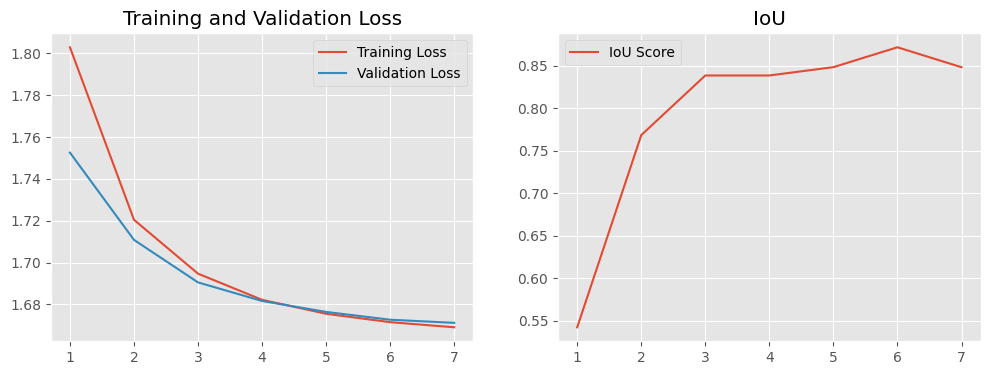

In [ ]:
import gc
model_scores = {}
EPOCHS = 7
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = CombinedLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
torch.cuda.empty_cache()
gc.collect()

for model_name, model in models.items():
    print(f"Training and validating model: {model_name}")
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    best_iou_score = train_and_validate(model, model_name, train_loader, valid_loader, optimizer, loss, metrics, DEVICE, EPOCHS)
    model_scores[model_name] = best_iou_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader, device, metrics):
    model.eval()
    metric_scores = {metric.__name__: [] for metric in metrics}
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            for metric in metrics:
                score = metric(outputs, targets)
                metric_scores[metric.__name__].append(score.item())

    avg_metric_scores = {metric: sum(scores) / len(scores) for metric, scores in metric_scores.items()}
    return avg_metric_scores


model_eval_scores = {}
for model_name, model in models.items():

    weight_path = f'/content/{model_name}_best.pth'
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model = model.to(device)

    avg_metric_scores = evaluate_model(model, test_loader, device, metrics)
    model_eval_scores[model_name] = avg_metric_scores

    print(f"Model: {model_name}")
    for metric_name, avg_score in avg_metric_scores.items():
        print(f'{metric_name}: {avg_score:.4f}')

Evaluating:   0%|          | 0/393 [00:00<?, ?it/s]

Model: Unet
iou_score: 0.8517


## DEEPLABV3

In [ ]:
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = "imagenet"
CLASSES = ['Health_brain', 'Tumor']  # Binary classification (background and tumor)
ACTIVATION = 'sigmoid'  # sigmoid activation for binary classification

aux_params = dict(
    pooling='avg',
    dropout=0.3,
    activation=ACTIVATION,
    classes=1,
)

common_params = {
    'encoder_name': ENCODER,
    'encoder_weights': ENCODER_WEIGHTS,
    'classes': 1,
    'activation': ACTIVATION,
    'aux_params': aux_params
}

models = {
    'Unet': smp.Unet(**common_params),
    'Unet++': smp.UnetPlusPlus(**common_params),
    #'MAnet': smp.MAnet(**common_params),
    #'Linknet': smp.Linknet(**common_params),
    #'FPN': smp.FPN(**common_params),
    #'PSPNet': smp.PSPNet(**common_params),
    'PAN': smp.PAN(**common_params),
    'DeepLabV3': smp.DeepLabV3(**common_params),
    'DeepLabV3+': smp.DeepLabV3Plus(**common_params),
}

Training and validating model: DeepLabV3


Epoch 1/7 [Train]:   0%|          | 0/354 [00:00<?, ?it/s]

Epoch 1/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 1, Train Loss: 1.7308, Valid Loss: 1.6883, IoU: 0.3906
Model saved to /content/DeepLabV3_best.pth with IoU: 0.3906


Epoch 2/7 [Train]:   0%|          | 0/354 [00:00<?, ?it/s]

Epoch 2/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 2, Train Loss: 1.6769, Valid Loss: 1.6779, IoU: 0.3717


Epoch 3/7 [Train]:   0%|          | 0/354 [00:00<?, ?it/s]

Epoch 3/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 3, Train Loss: 1.6697, Valid Loss: 1.6729, IoU: 0.5210
Model saved to /content/DeepLabV3_best.pth with IoU: 0.5210


Epoch 4/7 [Train]:   0%|          | 0/354 [00:00<?, ?it/s]

Epoch 4/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 4, Train Loss: 1.6670, Valid Loss: 1.6718, IoU: 0.6123
Model saved to /content/DeepLabV3_best.pth with IoU: 0.6123


Epoch 5/7 [Train]:   0%|          | 0/354 [00:00<?, ?it/s]

Epoch 5/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 5, Train Loss: 1.6656, Valid Loss: 1.6707, IoU: 0.5071


Epoch 6/7 [Train]:   0%|          | 0/354 [00:00<?, ?it/s]

Epoch 6/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 6, Train Loss: 1.6646, Valid Loss: 1.6700, IoU: 0.7845
Model saved to /content/DeepLabV3_best.pth with IoU: 0.7845


Epoch 7/7 [Train]:   0%|          | 0/354 [00:00<?, ?it/s]

Epoch 7/7 [Valid]:   0%|          | 0/708 [00:00<?, ?it/s]


Epoch: 7, Train Loss: 1.6640, Valid Loss: 1.6696, IoU: 0.7309


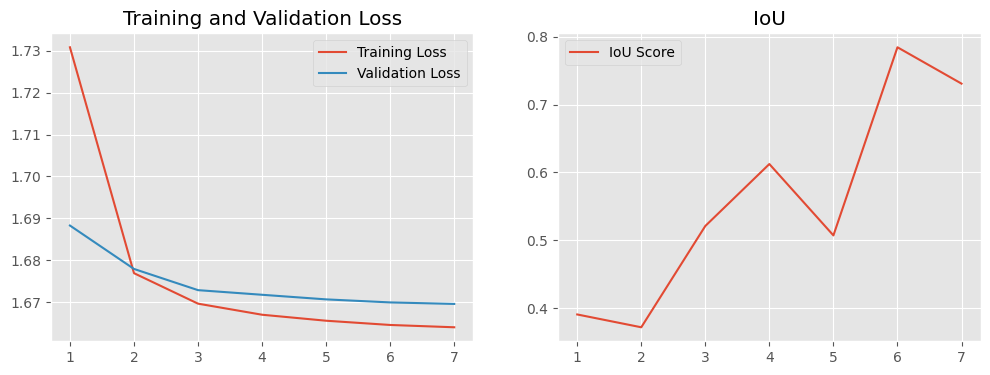

In [ ]:
import gc
model_scores = {}
EPOCHS = 7
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = CombinedLoss()
metrics = [smp.utils.metrics.IoU(threshold=0.5)]
torch.cuda.empty_cache()
gc.collect()

for model_name, model in models.items():
    print(f"Training and validating model: {model_name}")
    model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    best_iou_score = train_and_validate(model, model_name, train_loader, valid_loader, optimizer, loss, metrics, DEVICE, EPOCHS)
    model_scores[model_name] = best_iou_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader, device, metrics):
    model.eval()
    metric_scores = {metric.__name__: [] for metric in metrics}
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc="Evaluating"):
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            for metric in metrics:
                score = metric(outputs, targets)
                metric_scores[metric.__name__].append(score.item())

    avg_metric_scores = {metric: sum(scores) / len(scores) for metric, scores in metric_scores.items()}
    return avg_metric_scores


model_eval_scores = {}
for model_name, model in models.items():

    weight_path = f'/content/{model_name}_best.pth'
    model.load_state_dict(torch.load(weight_path, map_location=device))
    model = model.to(device)

    avg_metric_scores = evaluate_model(model, test_loader, device, metrics)
    model_eval_scores[model_name] = avg_metric_scores

    print(f"Model: {model_name}")
    for metric_name, avg_score in avg_metric_scores.items():
        print(f'{metric_name}: {avg_score:.4f}')

Evaluating:   0%|          | 0/393 [00:00<?, ?it/s]

Model: DeepLabV3
iou_score: 0.7986
